https://www.kaggle.com/c/predict-resignation-pytorch/overview

# Описание файлов
*   training_data.csv - набор данных для обучения
*   test_data.csv - набор данных для теста
*   sampleSubmission.ipynb - пример ноутбука с построением модели и подготовкой результата для загрузки на сервер

# Описание полей
Как обучающая выборка, так и тестовая содержат следующие характеристики автомобилей:

*   Age - возраст
*   BusinessTravel - частота командировок
*   Department - отдел
*   DistanceFromHome - расстояние от дома в км
*   Education - уровень образования
*   EducationField - сфера образования
*   Gender - пол
*   JobRole - должностная роль
*   MaritalStatus - семейное положение
*   MonthlyIncome - ежемесячный доход
*   NumCompaniesWorked - кол-во компаний, в которых работал сотрудник
*   PercentSalaryHike - процент повышения з/п за время работы
*   StandardHours - стандартная продолжительность рабочего дня
*   StockOptionLevel - уровень опциона на акции
*   TotalWorkingYears - общий трудовой стаж
*   TrainingTimesLastYear - общее время дополнительного обучения
*   YearsAtCompany - стаж работы в данной компании
*   YearsSinceLastPromotion - кол-во лет с последнего повышения
*   YearsWithCurrManager - кол-во лет работы с текущим менеджером
*   Attrition - ушел работник или нет, целевая переменная

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install catboost
!pip install eli5

     |████████████████████████████████| 64.8MB 54kB/s 
     |████████████████████████████████| 112kB 4.7MB/s 


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from catboost import CatBoostClassifier
from scipy import stats
import torch # чтобы определить активна ли видеокарта

import os
from itertools import product
from tqdm.notebook import tqdm

from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
DATA_PATH = '/content/drive/My Drive/Projects/Competitions/Employee resignation/data'
RESULT_PATH = '/content/drive/My Drive/Projects/Competitions/Employee resignation/result'
DEVICE = 'GPU' if torch.cuda.is_available() else 'CPU'
print(DEVICE)
RANDOM_STATE = 17

COLUMNS_MAP = {
    'Age': 'возраст',
    'BusinessTravel': 'частота командировок',
    'Department': 'отдел',
    'DistanceFromHome': 'расстояние от дома в км',
    'Education': 'уровень образования',
    'EducationField': 'сфера образования',
    'Gender': 'пол',
    'JobRole': 'должностная роль',
    'MaritalStatus': 'семейное положение',
    'MonthlyIncome': 'ежемесячный доход',
    'NumCompaniesWorked': 'кол-во компаний, в которых работал сотрудник',
    'PercentSalaryHike': 'процент повышения з/п за время работы',
    'StandardHours': 'стандартная продолжительность рабочего дня',
    'StockOptionLevel': 'уровень опциона на акции',
    'TotalWorkingYears': 'общий трудовой стаж',
    'TrainingTimesLastYear': 'общее время дополнительного обучения',
    'YearsAtCompany': 'стаж работы в данной компании',
    'YearsSinceLastPromotion': 'кол-во лет с последнего повышения',
    'YearsWithCurrManager': 'кол-во лет работы с текущим менеджером',
}

CPU


In [0]:
def fit_predict_catboost(model, X_train, y_train, X_valid):
    """
    обучение и получение предсказания для catboost
    """

    # индексы категориальных признаков
    categ_feat_idx = np.where(X_train.dtypes == 'object')[0]

    # обучение и предсказание
    fit_model = model.copy().fit(X_train, y_train, cat_features=categ_feat_idx) 
    y_pred = fit_model.predict(X_valid)
    y_pred_prob = fit_model.predict_proba(X_valid)[:,1]

    return fit_model, y_pred, y_pred_prob


def calc_metrics_catboost(model, X_train, y_train, X_valid, y_valid, model_name='catboost'):
    """
    подсчет метрик для необученной модели
    """
    if model_name == 'catboost':
        _, y_pred, y_pred_prob = fit_predict_catboost(model, X_train, y_train, X_valid)
    else:
        assert False, 'Модель {} не добавлена в функцию'.format(model_name)

    roc_auc = roc_auc_score(y_valid, y_pred_prob)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    return roc_auc, precision, recall


def calc_cv(X_df, y_df, n_splits, model, model_name='catboost', random_state=RANDOM_STATE, verbose=False):
    """
    Кросвалидация для catboost
    """
    
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    roc_auc_list = []
    precision_list = []
    recall_list = []

    for i, (train_index, val_index) in enumerate(kf.split(X_df)):
        
        X_train, X_valid = X_df.iloc[train_index, :], X_df.iloc[val_index, :]
        y_train, y_valid = y_df.iloc[train_index], y_df.iloc[val_index]        
        
        # подсчет метрик
        roc_auc, precision, recall = calc_metrics_catboost(model, X_train, y_train, X_valid, y_valid, model_name=model_name)

        roc_auc_list.append(roc_auc)
        precision_list.append(precision)
        recall_list.append(recall)

        if verbose:
            print( '\nFold #', i)
            print( '  roc_auc =', roc_auc)
            print( '  precision =', precision)
            print( '  recall =', recall)

    if verbose:
        print('\nmean_values:')
        print('  roc_auc =', np.mean(roc_auc_list))
        print('  precision =', np.mean(precision_list))
        print('  recall =', np.mean(recall_list))

    return roc_auc_list, precision_list, recall_list


def calc_grid_catboost(X_df, y_df, n_splits, params, result_file, max_iter=100, first_run=True, task_type=DEVICE, random_seed=RANDOM_STATE):
    """
    функция перебирает параметры
    """
    # строим сетку параметров
    if first_run:
        param_grid = pd.DataFrame(product(*params.values()), columns=params.keys())
        param_grid_result = param_grid.copy()
        param_grid_result['roc_auc'] = 0
        param_grid_result['precision'] = 0
        param_grid_result['recall'] = 0
    else:
        param_grid_result = pd.read_csv(result_file, sep=';')
        param_grid = param_grid_result.copy().drop(['roc_auc', 'precision', 'recall'], axis=1)

    # получаем случайные значения для индексов сетки и исключаем те, по которым уже получен результат
    indices_result = param_grid_result.query('roc_auc > 0').index.tolist()
    indices = np.random.choice(range(param_grid.shape[0]), size=min(max_iter, param_grid.shape[0]), replace=False)
    indices = indices[~np.isin(indices, indices_result)]

    for i in tqdm(indices):
        params_current = param_grid.iloc[i].to_dict()

        # две нижние строчки спроектированы для catboost, возможно переписать под другие модели
        ctb = CatBoostClassifier(random_seed=random_seed, silent=True, task_type=task_type, **params_current)
        roc_auc_list, precision_list, recall_list = calc_cv(X_df, y_df, n_splits=5, model=ctb, model_name='catboost', verbose=False)

        param_grid_result.loc[i, 'roc_auc'] = np.mean(roc_auc_list)
        param_grid_result.loc[i, 'precision'] = np.mean(precision_list)
        param_grid_result.loc[i, 'recall'] = np.mean(recall_list)

        # сохранение результата в файл
        param_grid_result.to_csv(result_file, sep=';', index=False)
    return param_grid_result

def get_best_params(param_grid_result):
    best_i = param_grid_result['roc_auc'].idxmax()

    roc_auc, precision, recall = param_grid_result.loc[best_i, ['roc_auc', 'precision', 'recall']]
    best_params = param_grid_result.loc[best_i].drop(['roc_auc', 'precision', 'recall'], axis=0).to_dict()
    return best_params, roc_auc, precision, recall

In [0]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def calc_cramers(feature1, feature2):
    confusion_matrix = pd.crosstab(feature1, feature2)
    return cramers_corrected_stat(confusion_matrix)

# графики для анализа категориальных признаков
def plot_feature_ptarget(data, feature, target, figsize=(22, 8), title=''):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(title, fontsize = 20)
    sns.countplot(x=feature, hue=target, data=data, ax=axes[0])
    data.groupby(by=feature)[target].mean().plot(kind='bar', ax=axes[1], rot=0)
    plt.show()

    cameras_value = calc_cramers(data[feature], data[target])
    print('Коэффициент крамера: {}'.format(cameras_value))

def plot_hist(feature, target, figsize):
    plt.figure(figsize=figsize)
    q = df[target] == 0
    plt.hist(df.loc[q, feature], bins=25, alpha=0.5, label='{} == 0'.format(target), color='b')
    plt.hist(df.loc[~q, feature], bins=25, alpha=0.5, label='{} == 1'.format(target), color='r')
    plt.legend(loc='upper right')
    plt.xlabel(feature);

In [0]:
df = pd.read_csv(os.path.join(DATA_PATH, 'training_data.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test_data.csv'))

In [0]:
df.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,Travel_Rarely,Sales,5.0,3,Technical Degree,Male,Sales Executive,Single,54050.0,4.0,14,8.0,0,10.0,2.0,8,7,104,0
1,45,Travel_Rarely,Sales,3.0,3,Life Sciences,Male,Healthcare Representative,Single,60740.0,0.0,14,8.0,0,9.0,2.0,8,3,1,0
2,51,Travel_Rarely,Sales,23.0,3,Medical,Female,Research Scientist,Married,192720.0,9.0,20,8.0,0,18.0,2.0,10,2,7,1
3,47,Travel_Rarely,Sales,15.0,4,Marketing,Female,Research Director,Married,65530.0,0.0,15,8.0,0,8.0,2.0,7,7,7,0
4,34,Travel_Rarely,Research & Development,21.0,3,Medical,Female,Laboratory Technician,Divorced,57704.0,3.0,117,8.0,1,7.0,4.0,0,0,0,0


In [0]:
df[['Education', 'StockOptionLevel']] = df[['Education', 'StockOptionLevel']].astype(str)

q_cat = df.drop('Attrition', axis=1).dtypes == 'object'
cat_columns = q_cat[q_cat].index.tolist()
num_columns = q_cat[~q_cat].index.tolist()

Доля уволившихся

In [0]:
df['Attrition'].mean()

0.15948601662887377

Наблюдается ожидаемый дисбаланс классов

Количество уникальных значений

In [0]:
df.nunique()

Age                          43
BusinessTravel                3
Department                    3
DistanceFromHome             30
Education                     5
EducationField                6
Gender                        2
JobRole                       9
MaritalStatus                 3
MonthlyIncome              1714
NumCompaniesWorked           11
PercentSalaryHike            43
StandardHours                 1
StockOptionLevel              4
TotalWorkingYears            41
TrainingTimesLastYear         8
YearsAtCompany               37
YearsSinceLastPromotion      16
YearsWithCurrManager         52
Attrition                     2
dtype: int64

*    Признак StandardHours ничего полезного не даст, потому что принимает всегда одно и тоже значение. Его следует исключить.

Количество пропусков

In [0]:
df.isnull().sum()

Age                        0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
Gender                     0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
Attrition                  0
dtype: int64

Корреляция (коэффициент Пирсона)

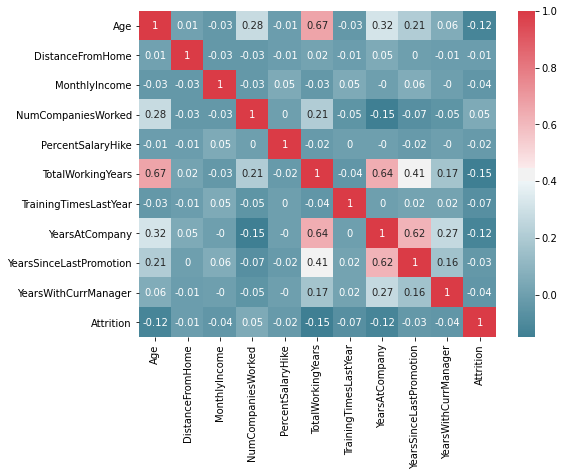

In [0]:
corr_p = del_StandardHours(df).corr().round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_p,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    annot=True,
);

Признаки с годами коррелируют между собой

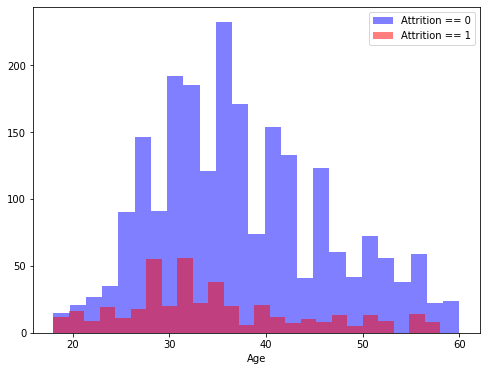

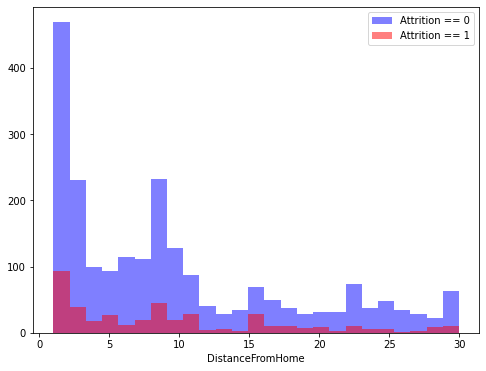

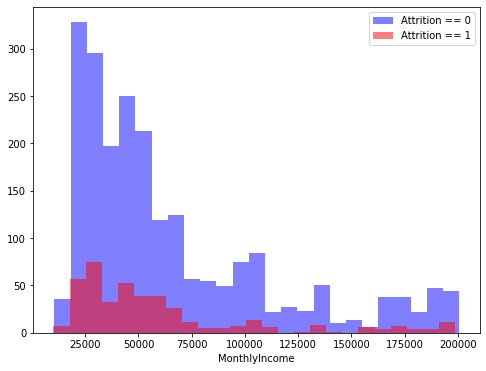

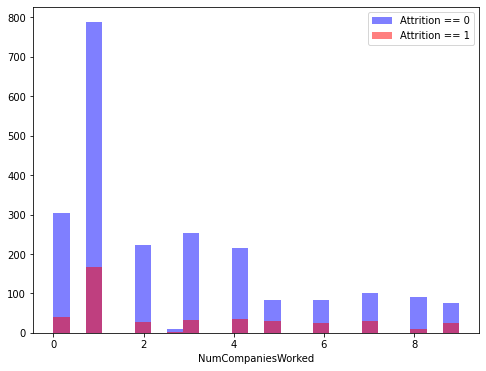

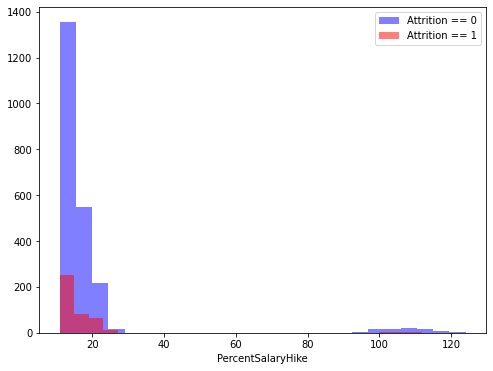

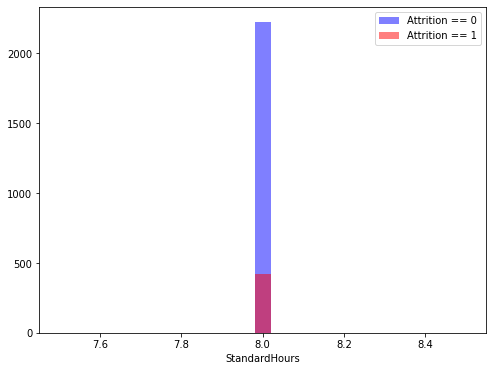

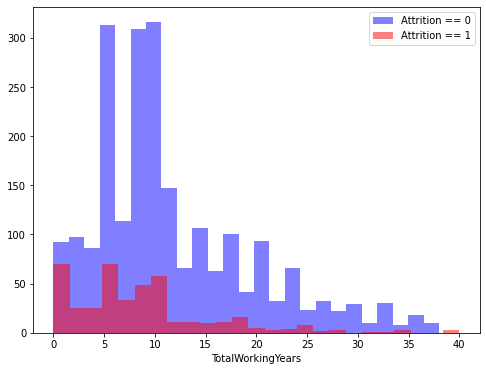

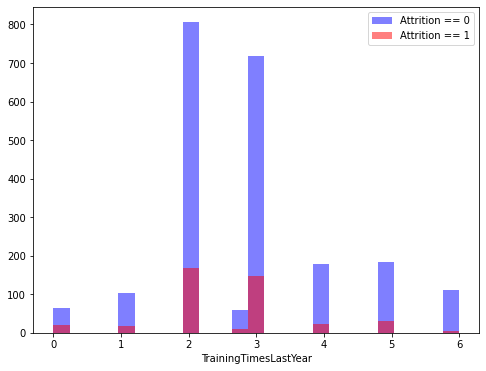

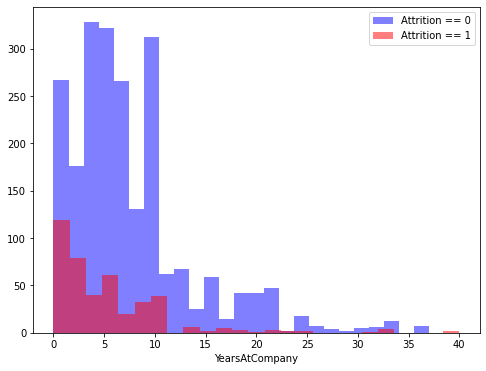

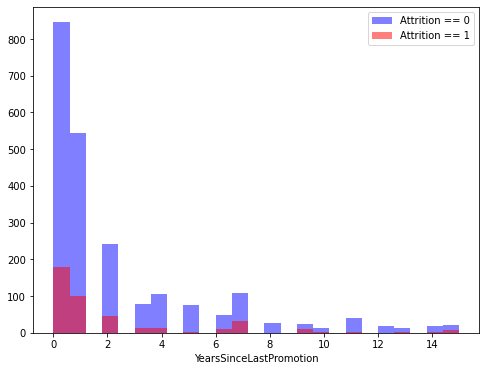

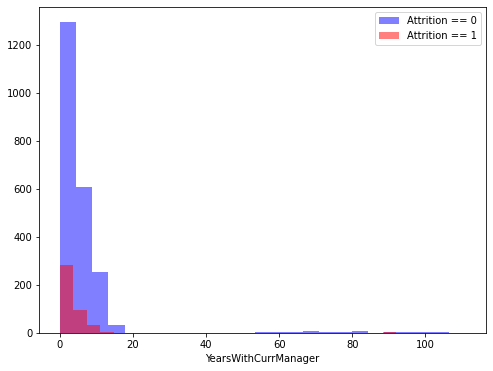

In [0]:
for column in num_columns:
    plot_hist(column, 'Attrition', figsize=(8,6))

Возможно смысл разбить на группы следующие признаки:
*    Age
*    DistanceFromHome
*    YearsWithCurrManager

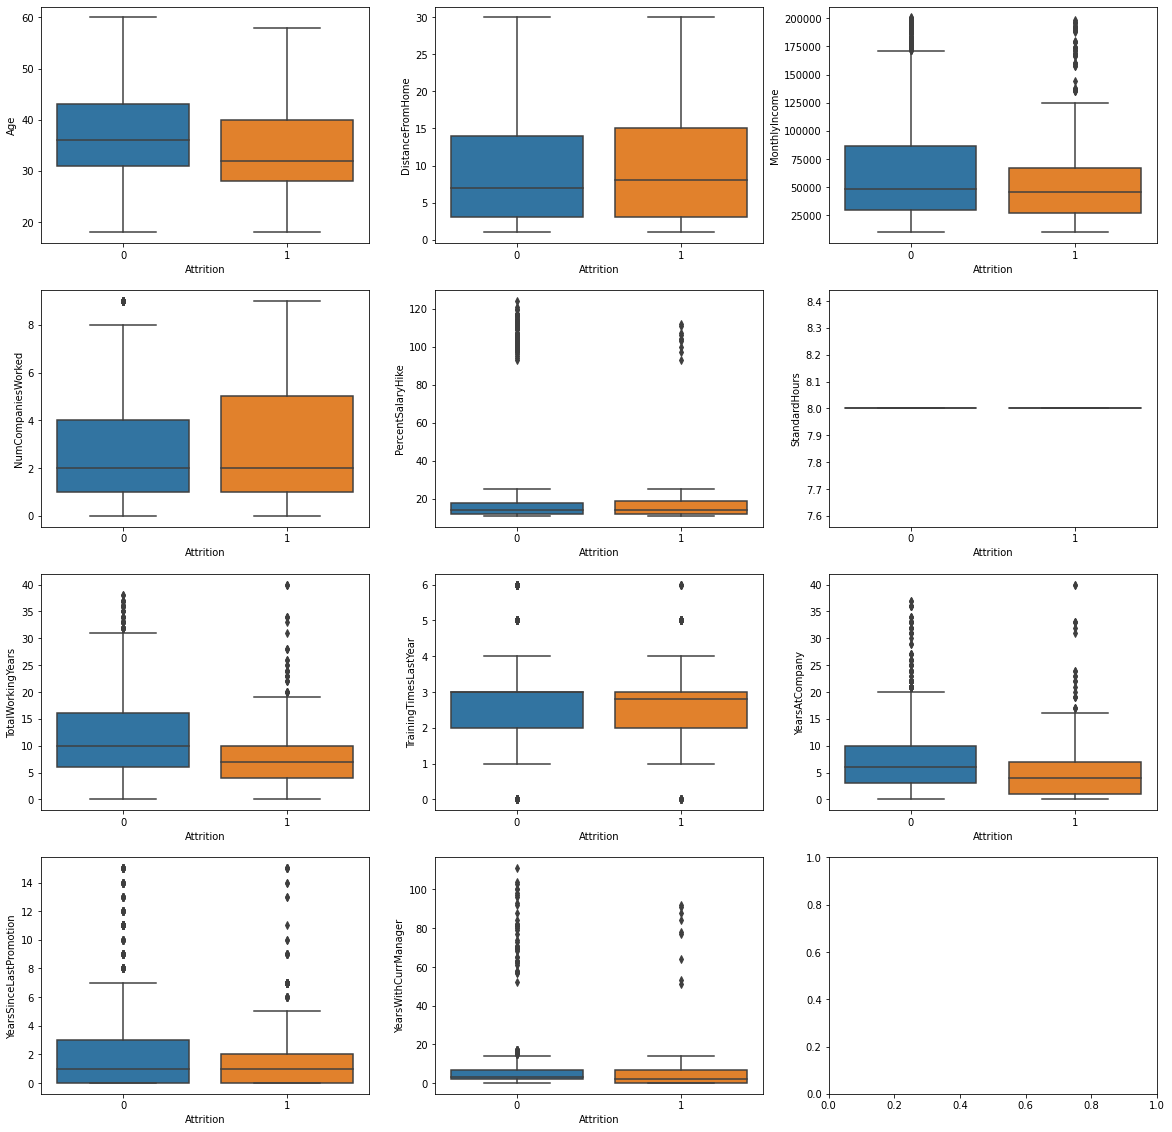

In [0]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for column, ax in zip(num_columns, axes.flatten()):
    sns.boxplot(x='Attrition', y=column, data=df, ax=ax)

Следующие признаки возможно не принесут полезный вклад в модель, т.к. различие между средними не слишком большое (можно проверить стат критерием, но врядли это поможет):
*    DistanceFromHome
*    PercentSalaryHike
*    TrainingTimesLastYear
*    YearsWithCurrManager

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


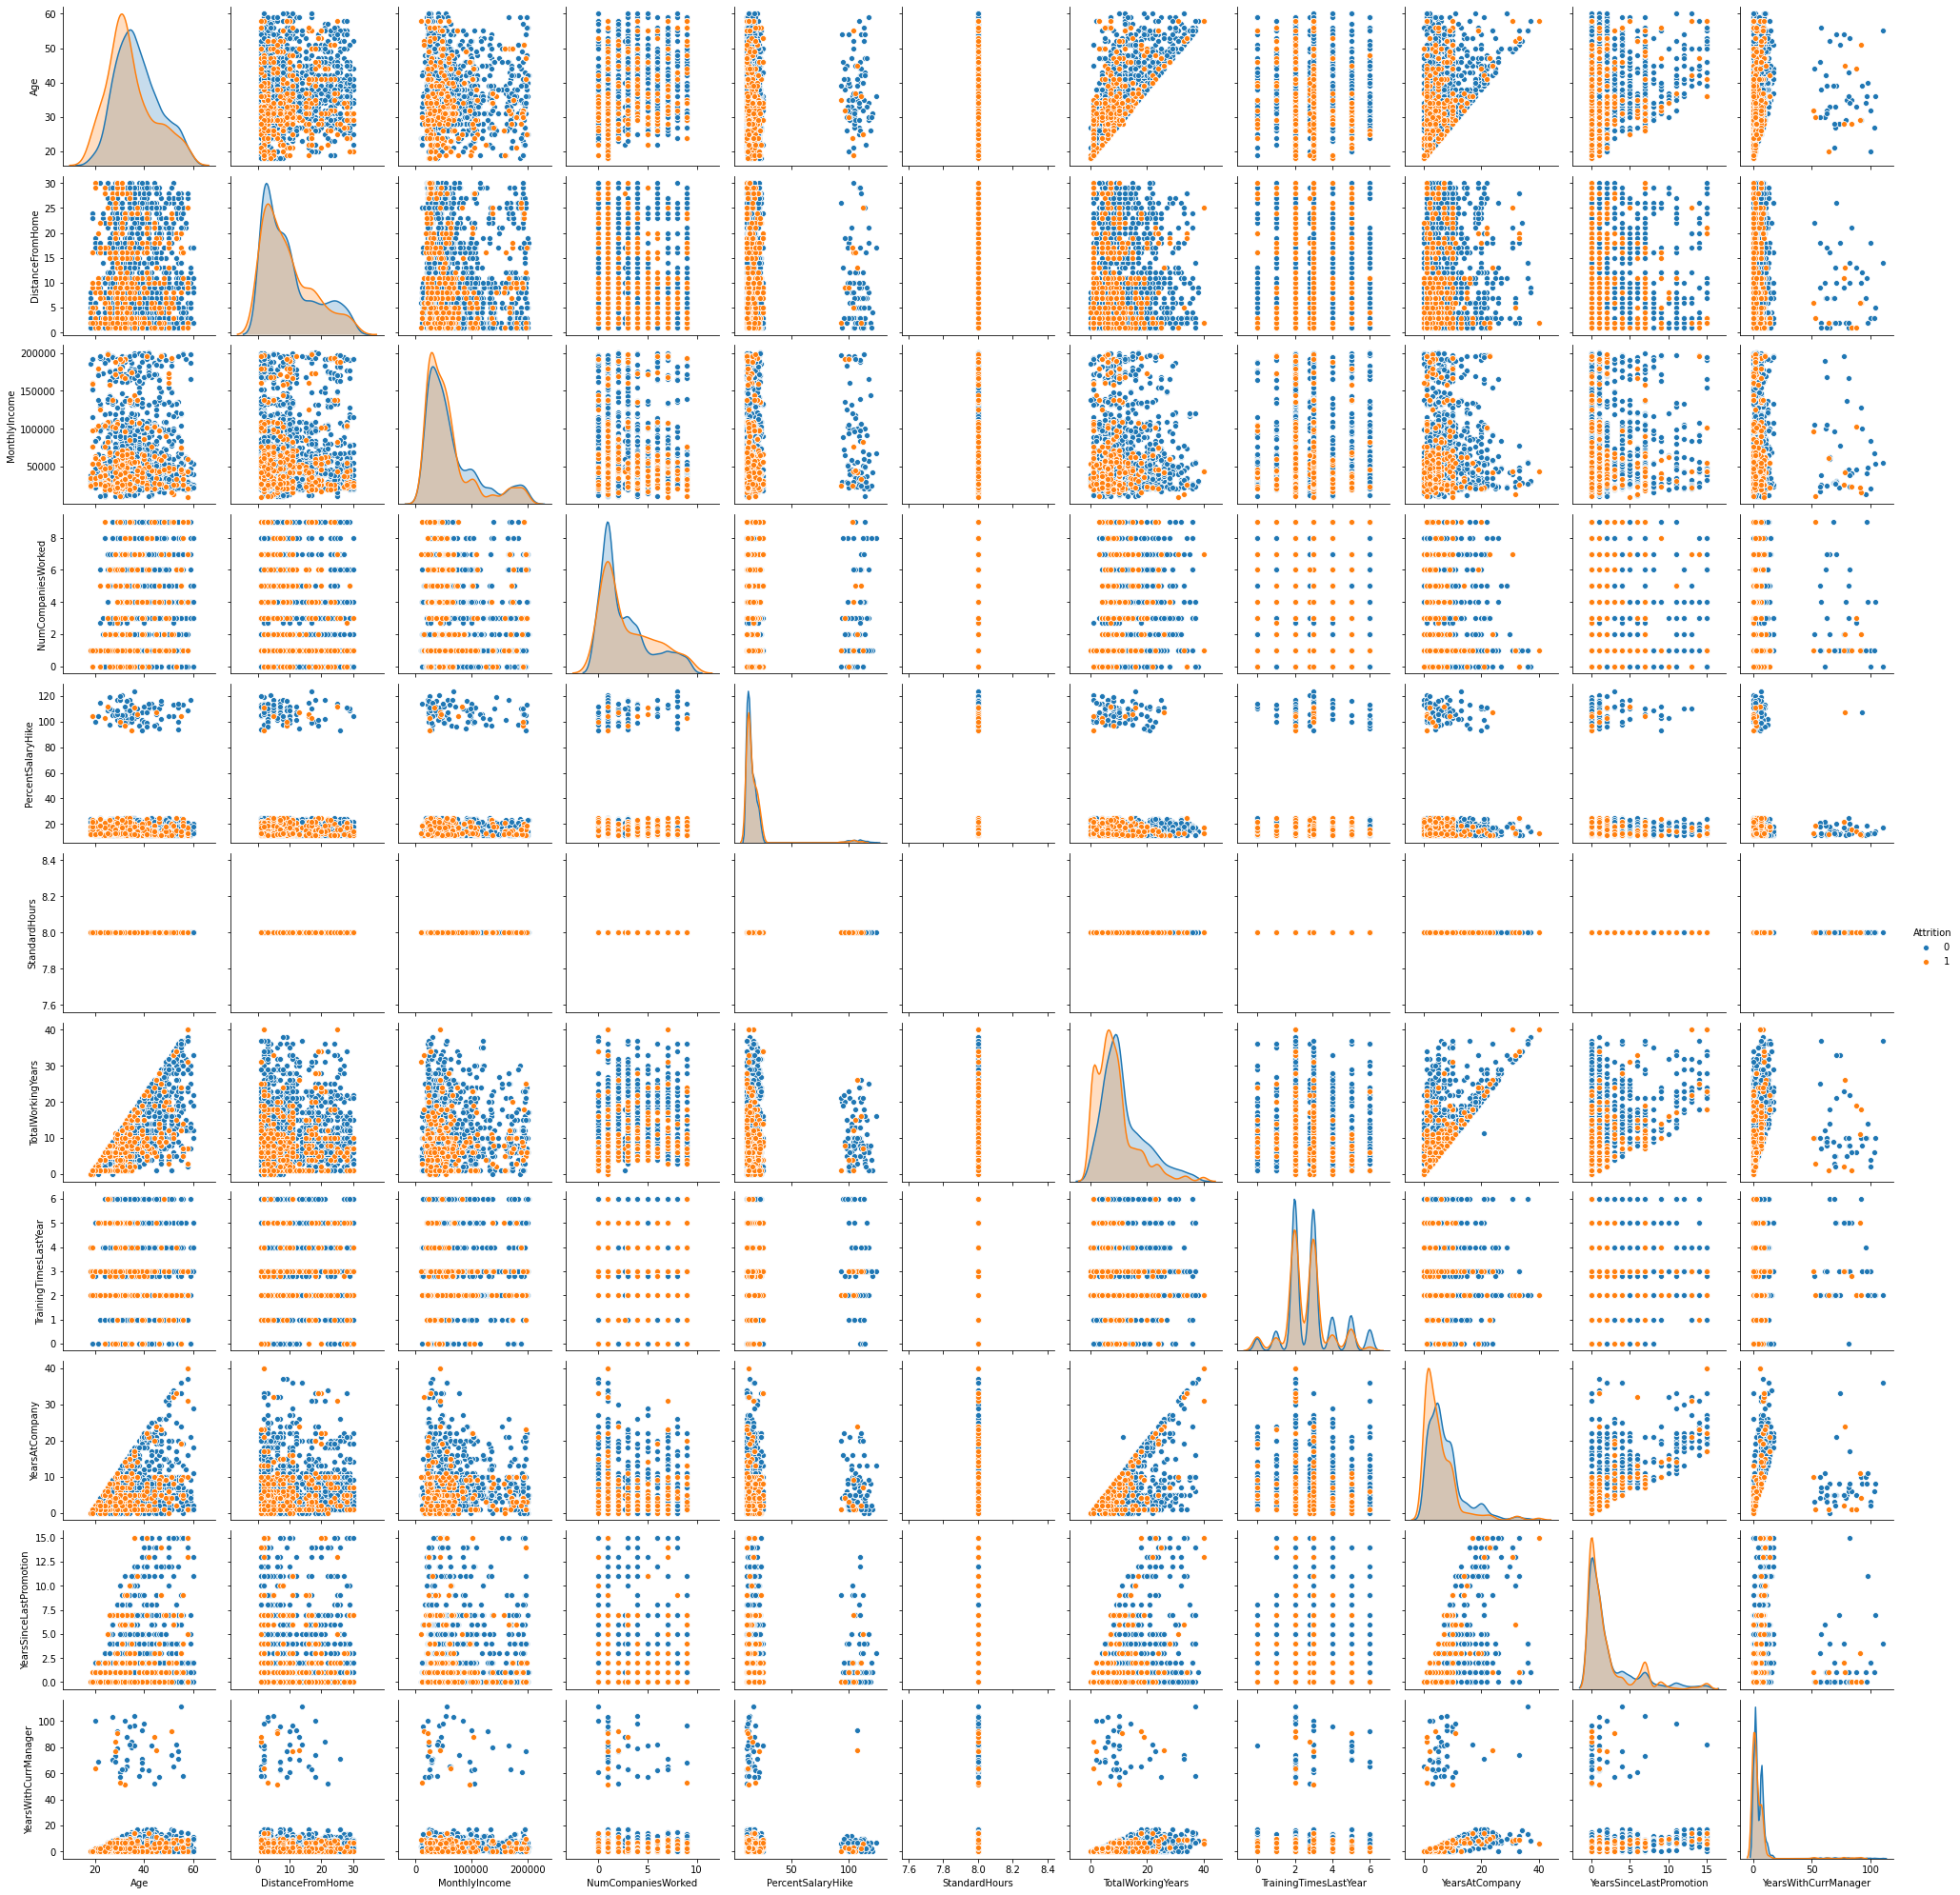

In [0]:
sns.pairplot(df[num_columns + ['Attrition']], hue="Attrition");

Коэффициент корреляции Крамера

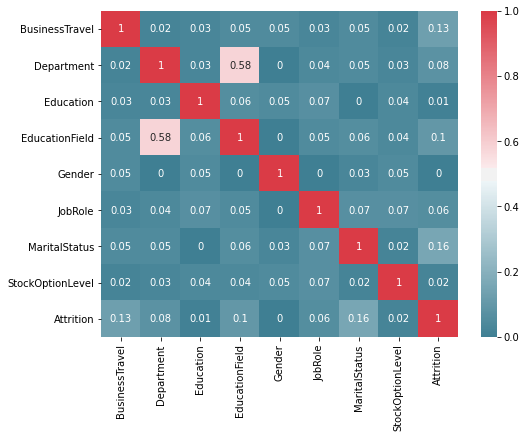

In [0]:
df_tmp = df[cat_columns + ['Attrition']].copy()

for column in cat_columns:
    encoder = LabelEncoder()
    df_tmp[column] = encoder.fit_transform(df[column].values)

corr_c = df_tmp.corr(method=calc_cramers).round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_c,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    annot=True,
);

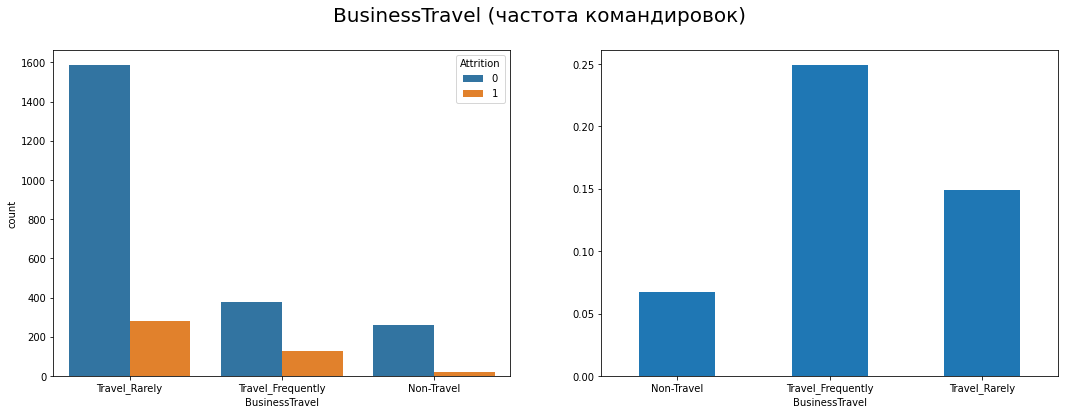

Коэффициент крамера: 0.13353608299699143


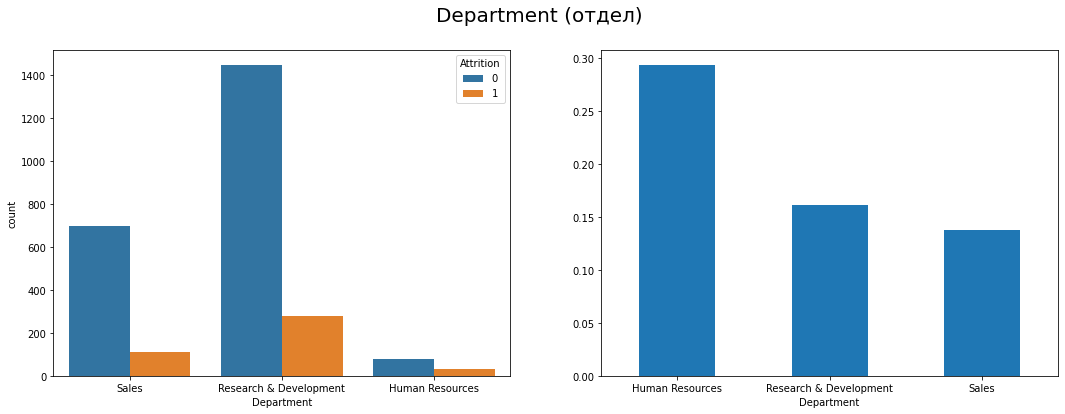

Коэффициент крамера: 0.07647786028032671


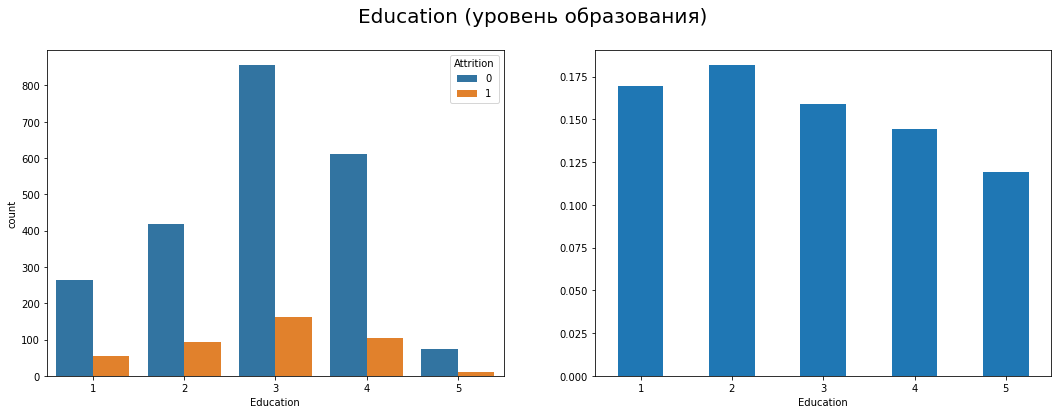

Коэффициент крамера: 0.011134934407318735


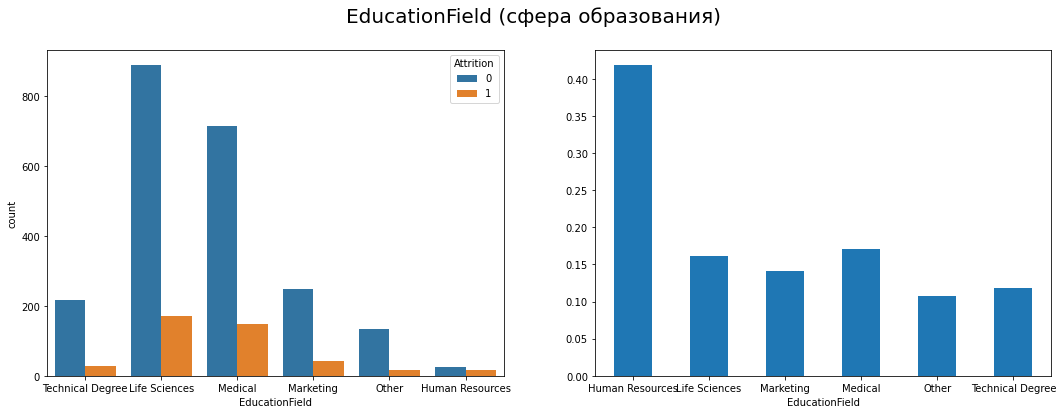

Коэффициент крамера: 0.09556525451650671


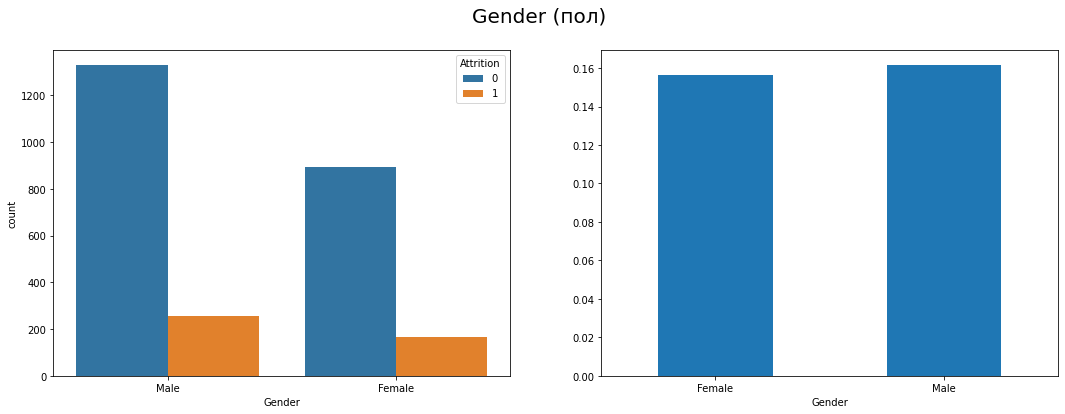

Коэффициент крамера: 0.0


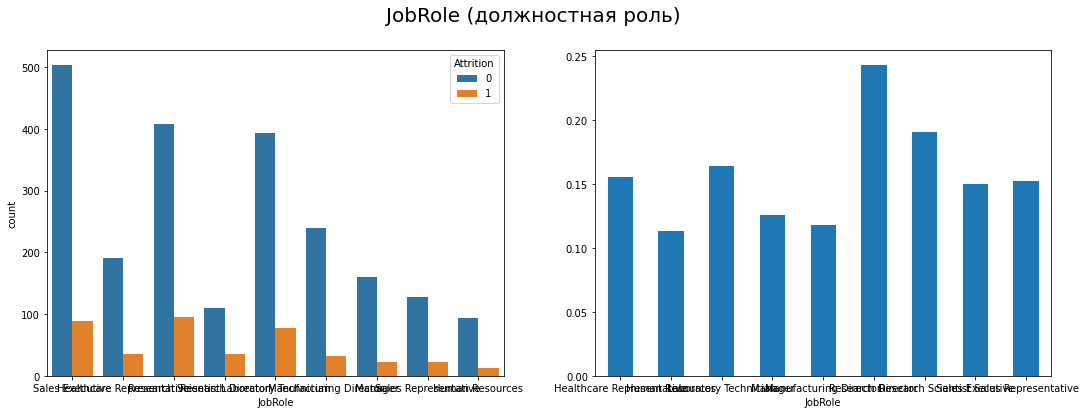

Коэффициент крамера: 0.0630552578946626


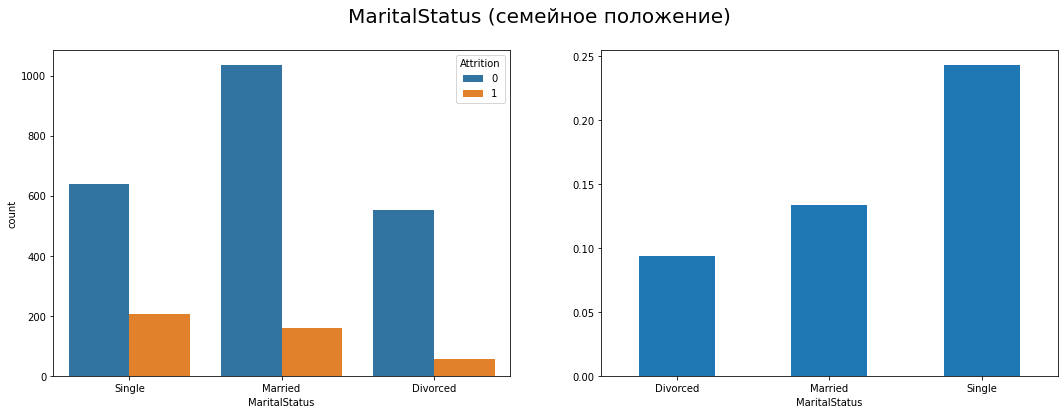

Коэффициент крамера: 0.15973497970546058


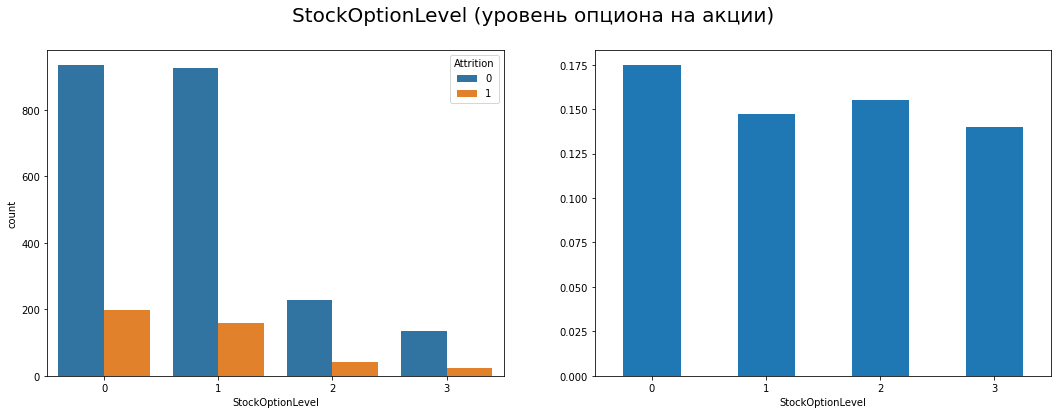

Коэффициент крамера: 0.015303510059995317


In [0]:
for column in cat_columns:
    plot_feature_ptarget(df, column, 'Attrition', figsize=(18, 6), title='{} ({})'.format(column, COLUMNS_MAP[column]))

Исходя из графиков и коэффциента Крамера видно, что наиболее интересными признаками являются:
*   MaritalStatus
*   BusinessTravel
*   EducationField

Также возможно поможет объединение некоторых признаков

# Добавление/удаление признаков

In [0]:
def del_StandardHours(df):
    return df.copy().drop('StandardHours', axis=1)

def combo(df, transform_funcs):
    """
    функция применяет все трансформации к данным
    """

    for func in transform_funcs:
        df = func(df)
    return df 

In [0]:
X_df = df.drop('Attrition', axis=1)
y_df = df['Attrition']

In [0]:
# без трансформаций

ctb = CatBoostClassifier(random_seed=RANDOM_STATE, silent=True, task_type='CPU')
roc_auc_list, precision_list, recall_list = calc_cv(
    X_df, y_df, 
    n_splits=2, model=ctb, model_name='catboost', verbose=True
)


Fold # 0
  roc_auc = 0.8621931900599304
  precision = 0.8387096774193549
  recall = 0.2826086956521739

Fold # 1
  roc_auc = 0.8241799945784765
  precision = 0.9444444444444444
  recall = 0.21428571428571427

mean_values:
  roc_auc = 0.8431865923192035
  precision = 0.8915770609318996
  recall = 0.24844720496894407


In [0]:
# без StandardHours

transform_funcs = [
    del_StandardHours,
]

ctb = CatBoostClassifier(random_seed=RANDOM_STATE, silent=True, task_type='CPU')
roc_auc_list, precision_list, recall_list = calc_cv(
    combo(X_df, transform_funcs), y_df, 
    n_splits=2, model=ctb, model_name='catboost', verbose=True
)


Fold # 0
  roc_auc = 0.8688304004275298
  precision = 0.8571428571428571
  recall = 0.2608695652173913

Fold # 1
  roc_auc = 0.8247415095070285
  precision = 0.9318181818181818
  recall = 0.1722689075630252

mean_values:
  roc_auc = 0.8467859549672792
  precision = 0.8944805194805194
  recall = 0.21656923639020825


# Подбор параметров на кросвалидации

In [0]:
# отложим часть данных на тест
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=RANDOM_STATE)

In [0]:
%%time

result_file = os.path.join(RESULT_PATH, 'result.csv')
params = {
    'depth':[6,10],
    'iterations':[1000,500,750],
    'learning_rate':[0.01218,0.03,0.05,0.1,0.2], 
    'loss_function': ['Logloss'],
    'l2_leaf_reg':[3,1,5,10],
    'border_count':[254,128,512],
}

# применим выбранные трансформации к данным
transform_funcs = [
    del_StandardHours,
]
X_train_modif = combo(X_train, transform_funcs)

# подбор параметров
param_grid_result = calc_grid_catboost(
    X_train_modif, y_train, 
    n_splits=2,
    params=params, 
    result_file=result_file, 
    max_iter=5000, 
    first_run=False, 
    random_seed=RANDOM_STATE
)


CPU times: user 2h 47min 26s, sys: 10min 28s, total: 2h 57min 54s
Wall time: 1h 34min 49s


In [0]:
result_file = os.path.join(RESULT_PATH, 'result.csv')
pd.read_csv(result_file, sep=';').dropna().sort_values('roc_auc', ascending=False).head(10)

,depth,iterations,learning_rate,loss_function,l2_leaf_reg,border_count,roc_auc,precision,recall
255,10,500,0.03,Logloss,1,254,0.924546,0.941391,0.568868
219,10,1000,0.10,Logloss,1,254,0.923762,0.956123,0.593710
279,10,500,0.10,Logloss,1,254,0.923399,0.948144,0.592664
317,10,750,0.03,Logloss,1,512,0.923391,0.916338,0.574788
315,10,750,0.03,Logloss,1,254,0.922454,0.929055,0.566630
196,10,1000,0.03,Logloss,1,128,0.921394,0.922717,0.565633
217,10,1000,0.10,Logloss,3,128,0.920929,0.921263,0.583009
337,10,750,0.10,Logloss,3,128,0.920737,0.925133,0.579087
207,10,1000,0.05,Logloss,1,254,0.919459,0.910582,0.562021
277,10,500,0.10,Logloss,3,128,0.919171,0.924944,0.572413


In [0]:
%%time

result_file = os.path.join(RESULT_PATH, 'result2.csv')
params = {
    'depth':[8,10,12,14,16],
    'iterations':[1000,1500,2000],
    'learning_rate':[0.03], 
    'loss_function': ['Logloss'],
    'l2_leaf_reg':[3,1],
    'border_count':[254,512],
}

# применим выбранные трансформации к данным
transform_funcs = [
    del_StandardHours,
]
X_train_modif = combo(X_train, transform_funcs)

# подбор параметров
param_grid_result = calc_grid_catboost(
    X_train_modif, y_train, 
    n_splits=2,
    params=params, 
    result_file=result_file, 
    max_iter=5000, 
    first_run=False, 
    random_seed=RANDOM_STATE
)

In [0]:
result_file = os.path.join(RESULT_PATH, 'result2.csv')
pd.read_csv(result_file, sep=';').dropna().sort_values('roc_auc', ascending=False).head(10)

,depth,iterations,learning_rate,loss_function,l2_leaf_reg,border_count,roc_auc,precision,recall
53,16,1500,0.03,Logloss,3,512,0.936802,0.980451,0.532371
49,16,1000,0.03,Logloss,3,512,0.936740,0.980451,0.532371
52,16,1500,0.03,Logloss,3,254,0.936643,0.980697,0.535597
55,16,1500,0.03,Logloss,1,512,0.936291,0.975094,0.548828
58,16,2000,0.03,Logloss,1,254,0.935896,0.971326,0.538300
38,14,1000,0.03,Logloss,1,254,0.934917,0.968622,0.550952
42,14,1500,0.03,Logloss,1,254,0.934838,0.968622,0.550952
46,14,2000,0.03,Logloss,1,254,0.934257,0.975765,0.554874
45,14,2000,0.03,Logloss,3,512,0.934114,0.959793,0.555570
43,14,1500,0.03,Logloss,1,512,0.932150,0.937333,0.544751


In [0]:
result_file = os.path.join(RESULT_PATH, 'result2.csv')
param_grid_result = pd.read_csv(result_file, sep=';')

best_params, roc_auc, precision, recall = get_best_params(param_grid_result)
print('best params:\n')
print(pd.Series(best_params))
print()
print('roc_auc =', roc_auc)
print('precision =', precision)
print('recall =', recall)

best params:

depth                 16
iterations          1500
learning_rate       0.03
loss_function    Logloss
l2_leaf_reg            3
border_count         512
dtype: object

roc_auc = 0.9368015021030024
precision = 0.9804511278195488
recall = 0.5323712954573432


# Проверка на отложенной выборке

In [0]:
ctb = CatBoostClassifier(random_seed=RANDOM_STATE, silent=True, task_type=DEVICE, **best_params)

# применим выбранные трансформации к данным
transform_funcs = [
    del_StandardHours,
]
X_train_modif = combo(X_train, transform_funcs)
X_test_modif = combo(X_test, transform_funcs)

roc_auc, precision, recall = calc_metrics_catboost(ctb, X_train_modif, y_train, X_test_modif, y_test)
print('roc_auc =', roc_auc)
print('precision =', precision)
print('recall =', recall)

roc_auc = 0.9651238591916558
precision = 0.975
recall = 0.6610169491525424


# Предсказание теста

In [0]:
ctb = CatBoostClassifier(random_seed=RANDOM_STATE, silent=True, task_type=DEVICE, **best_params)

# применим выбранные трансформации к данным
transform_funcs = [
    del_StandardHours,
]
X_df_modif = combo(X_df, transform_funcs)
df_test_modif = combo(df_test, transform_funcs)


fit_model, y_pred, y_pred_prob = fit_predict_catboost(ctb, X_df_modif, y_df, df_test_modif.drop('Id', axis=1))

final = df_test[['Id']].copy()
final['Attrition'] = y_pred_prob
final.to_csv(os.path.join(RESULT_PATH, 'final.csv'), index=False)

# Выводы
1. Проведен анализ данных. Написаны функции для трансформации данных (добавления и удаления признаков). Добавить хорошие признаки не успел.
2. Не успел реализовать подбор признаков (планировал с использованием библиотеки eli5). Далее отбирать признаки по следующей методике:
    * выбираем случайные 5, обучаемся, смотрим результат и так раз 100.
    * из лучших 5 вычитаем случайные 3, обучаемся, смотрим результат, повторяем несколько раз.
    * к лучшим 2 добавляем случайные 5, обучаемся, смотрим результат и так раз 100.
    * повторяем много раз
3. Выбрана модель catboost, т.к. в этой задаче много категориальных признаков, а эта модель вроде как с ними умеет хорошо работать
4. Реализована крос валидацию и подбор параметров (random search). Функция сохраняет промежуточный результат. Из-за ограниченного времени перебрал только 40 комбинаций параметров.
5. Не успел настроить и обучить другие модели, чтобы потом усреднить предсказание по всем - это улучит результат. Модели лучше выбирать разные по структуре, например нейронную сетку, случайный лес, регрессию (слабые модели лучше не использовать).
